# GOES lat/lon plotting example
This example steps through obtaining GOES data through an AWS S3 bucket, taking a subset based on lat/lon, and plotting the result.

Credits:
- [Lucas Sterzinger](mailto:lsterzinger@ucdavis.edu) - [Twitter](https://twitter.com/lucassterzinger) - University of California, Davis
- [Dr. Chelle Gentemann](mailto:gentemann@faralloninstitute.org) -  [Twitter](https://twitter.com/ChelleGentemann)   - Farallon Institute

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import s3fs
import datetime as dt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import dask
from dask.distributed import Client

## Get data
This function was written by Chelle Gentemann and was taken from https://github.com/oceanhackweek/ohw20-tutorials/blob/master/10-satellite-data-access/goes-cmp-netcdf-zarr.ipynb

It connects to the noaa-goes16/17 S3 bucket and pulls one day of data

In [2]:
def get_geo_data(sat,lyr,idyjl):
    # arguments
    # sat   goes-east,goes-west,himawari
    # lyr   year
    # idyjl day of year
    
    d = dt.datetime(lyr,1,1) + dt.timedelta(days=idyjl)
    fs = s3fs.S3FileSystem(anon=True) #connect to s3 bucket!

    #create strings for the year and julian day
    imon,idym=d.month,d.day
    syr,sjdy,smon,sdym = str(lyr).zfill(4),str(idyjl).zfill(3),str(imon).zfill(2),str(idym).zfill(2)
    
    #use glob to list all the files in the directory
    if sat=='goes-east':
        file_location,var = fs.glob('s3://noaa-goes16/ABI-L2-SSTF/'+syr+'/'+sjdy+'/*/*.nc'),'SST'
    if sat=='goes-west':
        file_location,var = fs.glob('s3://noaa-goes17/ABI-L2-SSTF/'+syr+'/'+sjdy+'/*/*.nc'),'SST'
    if sat=='himawari':
        file_location,var = fs.glob('s3://noaa-himawari8/AHI-L2-FLDK-SST/'+syr+'/'+smon+'/'+sdym+'/*/*L2P*.nc'),'sea_surface_temperature'
    
    #make a list of links to the file keys
    if len(file_location)<1:
        return file_ob
    file_ob = [fs.open(file) for file in file_location]        #open connection to files
    
    #open all the day's data
    ds = xr.open_mfdataset(file_ob,combine='nested',concat_dim='time') #note file is super messed up formatting
    
    #clean up coordinates which are a MESS in GOES
    #rename one of the coordinates that doesn't match a dim & should
    if not sat=='himawari':
        ds = ds.rename({'t':'time'})
        ds = ds.reset_coords()
    else:
        ds = ds.rename({'ni':'x','nj':'y'}) #for himawari change dims to match goes 
    
    #put in to Celsius
    #ds[var] -= 273.15   #nice python shortcut to +- from itself a-=273.15 is the same as a=a-273.15
    #ds[var].attrs['units'] = '$^\circ$C'
   
    return ds


### Get the data from the 210th day of 2020

In [3]:
%%time
ds = get_geo_data("goes-east", 2020, 210)

CPU times: user 19.3 s, sys: 7.19 s, total: 26.5 s
Wall time: 4min 4s


***
# Get lat/lon
This function uses metadata stored in the `goes_imager_projection` variable that is present in GOES data. It adds a `lat` and `lon` coordinate to the dataset. The math to convert from the GOES x/y grid to lat/lon was taken from https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm 

In [4]:
def calc_latlon(ds):
    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"

    return ds

In [5]:
%%time
ds = calc_latlon(ds)

<ipython-input-4-7724a1894034>:18: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


CPU times: user 3.45 s, sys: 595 ms, total: 4.05 s
Wall time: 4.05 s


### Now, our dataset has lat and lon coordinates

In [6]:
ds.coords

Coordinates:
  * time     (time) datetime64[ns] 2020-07-28T00:30:05.934142976 ... 2020-07-...
  * y        (y) float32 0.1518 0.1518 0.1517 0.1517 ... -0.1517 -0.1518 -0.1518
  * x        (x) float32 -0.1518 -0.1518 -0.1517 ... 0.1517 0.1518 0.1518
    lat      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    lon      (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan

## Use `.sel()` to select based on GOES coordinates

/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


CPU times: user 6.47 s, sys: 2.68 s, total: 9.15 s
Wall time: 1min 18s


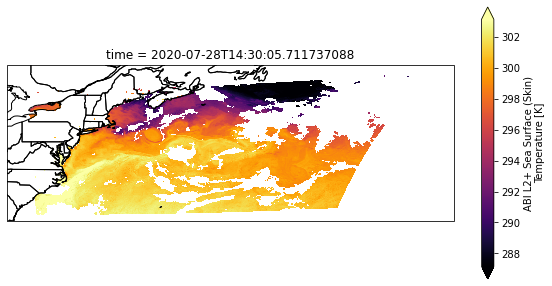

In [7]:
%%time
subset = ds.sel(x=slice(-0.01,0.07215601),y=slice(0.12,0.09))  #reduce to GS region

masked = subset.SST.where(subset.DQF==0)
# p = None
fig = plt.figure(figsize=(10,5))
p = masked.isel(time=14).plot(x='lon', y='lat',vmin=14+273.15,vmax=30+273.15,cmap='inferno', subplot_kws={
    "projection" : ccrs.PlateCarree()
})
p.axes.coastlines()
p.axes.add_feature(cfeature.STATES)

### Plot mean over time

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


CPU times: user 2min 29s, sys: 1min 6s, total: 3min 35s
Wall time: 31min 35s


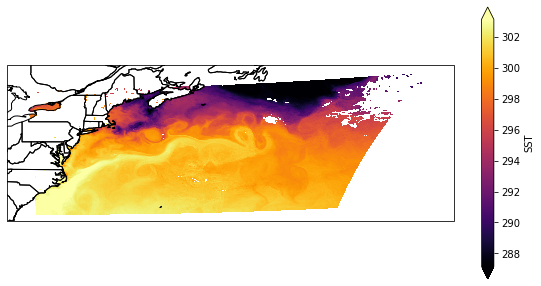

In [10]:
%%time
subset = ds.sel(x=slice(-0.01,0.07215601),y=slice(0.12,0.09))  #reduce to GS region

masked = subset.SST.where(subset.DQF==0)
# p = None
fig = plt.figure(figsize=(10,5))
p = masked.mean("time", skipna=True).plot(x='lon', y='lat',vmin=14+273.15,vmax=30+273.15,cmap='inferno', subplot_kws={
    "projection" : ccrs.PlateCarree()
})
p.axes.coastlines()
p.axes.add_feature(cfeature.STATES)

# Select a subset of data

In [6]:
lat1, lat2 = 21, 43
lon1, lon2 = -84, -56

### Chunking data makes it easier and faster for the system to process large array operations

In [7]:
ds= ds.chunk({
    "x": 1000,
    "y": 1000,
    "time":1
})

In [8]:
subset = ds.where((ds.lon >= lon1) & (ds.lon <= lon2) & (ds.lat >= lat1) & (ds.lat <= lat2), drop=True)

subset = subset.SST.where(subset.DQF == 0).mean("time")

This subset can be plotted directly from xarray

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 2min 11s, sys: 1min 18s, total: 3min 30s
Wall time: 33min 49s


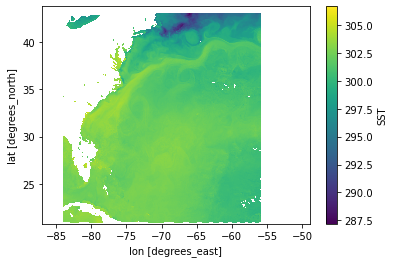

In [32]:
%%time
subset.plot(x="lon", y="lat")

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 2min 15s, sys: 1min 23s, total: 3min 38s
Wall time: 36min 16s


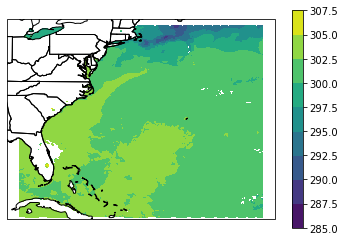

In [10]:
%%time
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
cs = ax.contourf(subset.lon, subset.lat, subset)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
plt.colorbar(cs)